##### Author: Pablo Iañez Picazo 
##### Biomedical Data Science lab, ISGlobal

In [1]:
# Load all the necessary libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import umap

random.seed(22)
sns.set_style("ticks")

# Supress all warnings
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("/home/pianez/phd/projects/hsc_nucleus/hsc_rhoa")
from methods import hsc_spatial_stats as hsc
from globals import new_names

2025-08-29 11:34:23.789708: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-29 11:34:24.082706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-29 11:34:24.082858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-29 11:34:24.116611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-29 11:34:24.194908: I tensorflow/core/platform/cpu_feature_guar

In [2]:
sns.set(rc={"figure.figsize": (20, 16)})
sns.set_style("whitegrid")

In [3]:
# ------------------------ Set up some parameters --------------------------- #
# Image resolution after resizing, which is 5 micrometers per pixel
res = 0.1
# cluster forming threshold - threshold at which intensities above this value
# will be considered belonging to a DAPI-Intense Region (DIR)
# Intensities to 0.6 are the one in the quantile 0.80 in young, old and treated
cft = 0.6
normalization = "z_score"
folder = "data/preprocessed/"
conditions = [
    "young",
    "aged",
    "aged_treated_RhoAi",
    "myeloid_progenitors",
]

palette = {
    "Young": (0.00392, 0.45098, 0.69803),
    "Aged": (0.00784, 0.61960, 0.45098),
    "Aged + Ri": (0.8, 0.47058, 0.73725),
    "MP": (0.76868, 0.30588, 0.32156),
}

In [4]:
nuc_df = pd.read_csv(
    f"results/z_score_nuclei_3d_res{res}_cf{cft}_filt_df.csv", index_col=0
)
nuc_df = hsc.fix_labels(nuc_df)

In [6]:
# I have left out those features that are highly correlated with others
# Correlation higher than 0.9 or lower than -0.9
features = [
    "volume",
    "width",
    "length",
    "height",
    "height deviation",
    "aspect ratio",
    "major axis length",
    "minor axis length",
    "min intensity",
    "max intensity",
    "solidity",
    "surface area",
    "sphericity",
    "invagination proportion",
    "DIRs volume",
    "DIRs width",
    "DIRs length",
    "DIRs height",
    "intensity 0-0.5µm",
    "intensity 1-1.5µm",
    "intensity ratio",
    "DIRs aspect ratio",
    "DIRs surface area",
    "DIRs major axis length",
    "DIRs sphericity",
    "DIRs surface/volume",
    "DIRs mean intensity",
    "DIRs max intensity",
    "DIRs solidity",
    "DIRs centroid distance to border",
    "DIRs distance to border",
    "number of DIRs",
    "largest slide area",
    "largest slide major axis length",
    "largest slide minor axis length",
    "largest slide perimeter",
    "largest slide roundness",
    "largest slide compactness",
    "largest slide EOP",
    "condition",
    "im_path",
    "im_batch",
    "im_nuc",
]

print(len(features[:-4]))

subset_df = nuc_df[nuc_df["condition"].isin(["Young", "Aged", "Aged + Ri"])]
subset_df = subset_df.rename(columns=new_names)
subset_df = subset_df[features]

# Drop columns that contain NaN values
subset_df = subset_df.dropna()

39


In [7]:
subset_df.condition.value_counts()

condition
Young        177
Aged         164
Aged + Ri    144
Name: count, dtype: int64

In [8]:
pv_df = hsc.get_p_values(
    subset_df,
    subset_df.columns[:-3],
    by_col="condition",
    group1="Young",
    group2="Aged",
)

In [9]:
pv_df.sort_values(by="p_float", ascending=True)

,p_float,p_string,significance,<0.05,<0.01,<0.001
largest slide compactness,5.006572e-07,0.00000,***,True,True,True
largest slide area,6.946391e-07,0.00000,***,True,True,True
largest slide minor axis length,1.456098e-06,0.00000,***,True,True,True
surface area,5.535159e-06,0.00001,***,True,True,True
largest slide perimeter,8.033974e-06,0.00001,***,True,True,True
length,1.333679e-05,0.00001,***,True,True,True
volume,2.756659e-05,0.00003,***,True,True,True
intensity 1-1.5µm,3.609972e-05,0.00004,***,True,True,True
minor axis length,6.181149e-05,0.00006,***,True,True,True
intensity ratio,8.773339e-05,0.00009,***,True,True,True


In [10]:
sig_f = pv_df[pv_df["<0.05"]].index.to_list()
sig_f

['volume',
 'width',
 'length',
 'aspect ratio',
 'minor axis length',
 'min intensity',
 'surface area',
 'DIRs volume',
 'DIRs length',
 'DIRs height',
 'intensity 0-0.5µm',
 'intensity 1-1.5µm',
 'intensity ratio',
 'DIRs major axis length',
 'DIRs mean intensity',
 'DIRs max intensity',
 'DIRs centroid distance to border',
 'DIRs distance to border',
 'largest slide area',
 'largest slide major axis length',
 'largest slide minor axis length',
 'largest slide perimeter',
 'largest slide compactness']

In [11]:
corrmat = subset_df[sig_f].corr()
corrmat = corrmat.rename_axis(None).rename_axis(None, axis=1)
corrmat = corrmat.stack().reset_index()
corrmat.columns = ["var_1", "var_2", "correlation"]
corrmat = corrmat[corrmat["correlation"] != 1]
corrmat.sort_values(by="correlation", ascending=False).head(20)

,var_1,var_2,correlation
385,DIRs centroid distance to border,DIRs distance to border,0.979625
407,DIRs distance to border,DIRs centroid distance to border,0.979625
6,volume,surface area,0.976962
138,surface area,volume,0.976962
435,largest slide area,largest slide perimeter,0.968934
501,largest slide perimeter,largest slide area,0.968934
308,DIRs major axis length,DIRs height,0.937763
220,DIRs height,DIRs major axis length,0.937763
458,largest slide major axis length,largest slide perimeter,0.880278
502,largest slide perimeter,largest slide major axis length,0.880278


In [12]:
corrmat.sort_values(by="correlation", ascending=False).tail(20)

,var_1,var_2,correlation
508,largest slide compactness,length,-0.714359
68,length,largest slide compactness,-0.714359
507,largest slide compactness,width,-0.731904
45,width,largest slide compactness,-0.731904
512,largest slide compactness,surface area,-0.746747
160,surface area,largest slide compactness,-0.746747
506,largest slide compactness,volume,-0.753872
22,volume,largest slide compactness,-0.753872
265,intensity 1-1.5µm,intensity ratio,-0.777175
287,intensity ratio,intensity 1-1.5µm,-0.777175


In [13]:
sig_f_clean = [
    "volume",
    "width",
    "length",
    "aspect ratio",
    # "minor axis length",
    "min intensity",
    # "surface area",
    "DIRs volume",
    "DIRs length",
    # "DIRs height",
    # "intensity 0-0.5µm",
    "intensity 1-1.5µm",
    # "intensity ratio",
    "DIRs major axis length",
    "DIRs mean intensity",
    # "DIRs max intensity",
    # "DIRs centroid distance to border",
    "DIRs distance to border",
    # "largest slide area",
    # "largest slide major axis length",
    # "largest slide minor axis length",
    # "largest slide perimeter",
    # "largest slide compactness",
]

In [14]:
corrmat = subset_df[sig_f_clean].corr()
corrmat = corrmat.rename_axis(None).rename_axis(None, axis=1)
corrmat = corrmat.stack().reset_index()
corrmat.columns = ["var_1", "var_2", "correlation"]
corrmat = corrmat[corrmat["correlation"] != 1]
corrmat.sort_values(by="correlation", ascending=False).head(20)

,var_1,var_2,correlation
93,DIRs major axis length,DIRs volume,0.705157
63,DIRs volume,DIRs major axis length,0.705157
61,DIRs volume,DIRs length,0.675305
71,DIRs length,DIRs volume,0.675305
117,DIRs distance to border,intensity 1-1.5µm,0.651562
87,intensity 1-1.5µm,DIRs distance to border,0.651562
2,volume,length,0.632709
22,length,volume,0.632709
11,width,volume,0.568779
1,volume,width,0.568779


In [15]:
corrmat.sort_values(by="correlation", ascending=False).tail(20)

,var_1,var_2,correlation
90,DIRs major axis length,length,-0.160741
30,length,DIRs major axis length,-0.160741
92,DIRs major axis length,min intensity,-0.164742
52,min intensity,DIRs major axis length,-0.164742
67,DIRs length,width,-0.177379
17,width,DIRs length,-0.177379
80,intensity 1-1.5µm,aspect ratio,-0.189570
40,aspect ratio,intensity 1-1.5µm,-0.189570
19,width,DIRs major axis length,-0.191954
89,DIRs major axis length,width,-0.191954


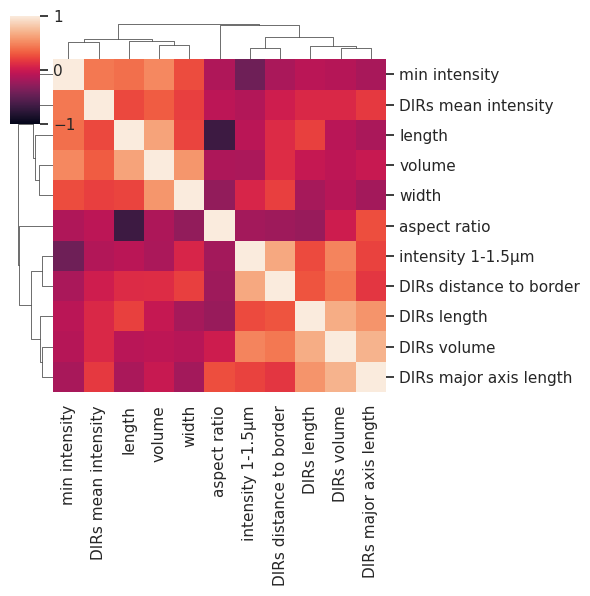

In [16]:
sns.clustermap(
    subset_df[sig_f_clean].corr(),
    dendrogram_ratio=0.1,
    vmin=-1,
    vmax=1,
    figsize=(6, 6),
)

In [17]:
subset_df = subset_df[subset_df["condition"].isin(["Young", "Aged"])]
subset_df.reset_index(drop=True, inplace=True)

<Figure size 1000x600 with 0 Axes>

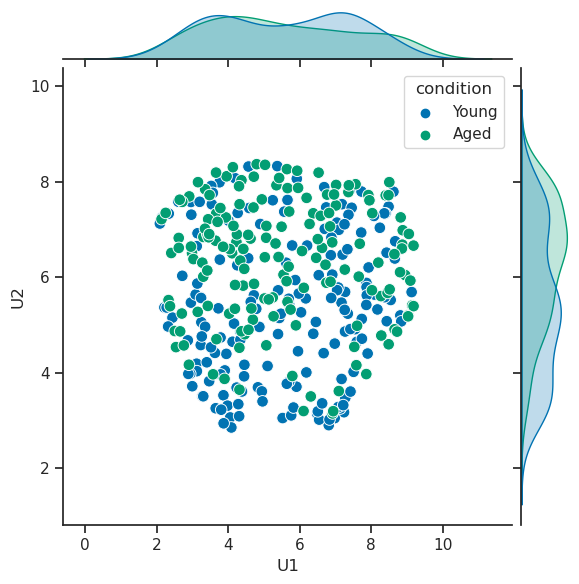

In [18]:
from sklearn.preprocessing import StandardScaler

sns.set_style("ticks")
# Create the UMAP object
reducer = umap.UMAP(
    min_dist=0.2,
    n_neighbors=15,
    n_components=2,
    random_state=2023,
    metric="euclidean",
)

# Extract numerical data
x = subset_df[sig_f_clean].values

# Learn the scaler on the young and confined cells and apply
# it to the old and treated cells
transformer = StandardScaler()
x = transformer.fit_transform(x)

# Learn the UMAP on the young and confined cells and apply
# it to the old and treated cells
embedding = reducer.fit_transform(x)
umap_df = pd.DataFrame(data=embedding, columns=["U1", "U2"])
umap_df = pd.concat([umap_df, subset_df[features]], axis=1)

plt.figure(figsize=(10, 6))
plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    s=70,
    palette=palette,
    height=6,
    ratio=8,
)
# plot.ax_marg_x.set_xlim(3, 12)
# plot.ax_marg_y.set_ylim(1, 8)

<Figure size 1000x600 with 0 Axes>

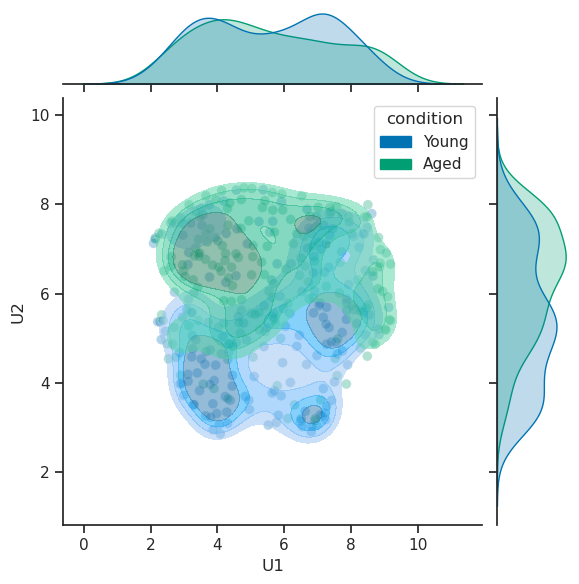

In [19]:
plt.figure(figsize=(10, 6))
plot = sns.jointplot(
    data=umap_df,
    x="U1",
    y="U2",
    hue="condition",
    kind="scatter",
    s=50,
    palette=palette,
    alpha=0.3,
)
plot.plot_joint(
    sns.kdeplot,
    data=umap_df,
    hue="condition",
    kind="kde",
    fill=True,
    levels=5,
    thresh=0.3,
    alpha=0.5,
    bw_adjust=0.75,
    palette=palette,
)
# plot.ax_marg_x.set_xlim(2, 13)
# plot.ax_marg_y.set_ylim(4, 12)